In [1]:
import numpy as np

# Creating Grids

In [34]:
class GridDelta():
	def __init__(self,xdelta,ydelta,zdelta):
		"""Initialize grid deltas in feet. Internally stored in meters."""
		self.xdelta = xdelta # ft
		self.ydelta = ydelta # ft
		self.zdelta = zdelta # ft

	@property
	def xdelta(self):
		return self._xdelta/0.3048
	
	@xdelta.setter
	def xdelta(self,value):
		self._xdelta = np.asarray(value).flatten().astype(np.float64)*0.3048

	@property
	def ydelta(self):
		return self._ydelta/0.3048

	@ydelta.setter
	def ydelta(self,value):
		self._ydelta = np.asarray(value).flatten().astype(np.float64)*0.3048

	@property
	def zdelta(self):
		return self._zdelta/0.3048

	@zdelta.setter
	def zdelta(self,value):
		self._zdelta = np.asarray(value).flatten().astype(np.float64)*0.3048

	def __call__(self):

		_xdelta = np.tile(self._xdelta,self.ynums*self.znums)
		_ydelta = np.tile(np.repeat(self._ydelta,self.xnums),self.znums)
		_zdelta = np.repeat(self._zdelta,self.xnums*self.ynums)

		return _xdelta,_ydelta,_zdelta

	@property
	def _volume(self):
		return np.prod(self.__call__(),axis=0)

	@property
	def volume(self):
		return self._volume*35.3147

	@property
	def index(self):
		return np.arange(self.nums)

	@property
	def map(self):
		"""Plat of grids that locates neighbor index information."""
		map_ = np.tile(self.index,(self.dims*2,1)).T

		map_[self.index.reshape(-1,self.xnums)[:,1:].ravel(),0] -= 1
		map_[self.index.reshape(-1,self.xnums)[:,:-1].ravel(),1] += 1

		if self.dims>1:
			map_[self.index.reshape(self.znums,-1)[:,self.xnums:],2] -= self.xnums
			map_[self.index.reshape(self.znums,-1)[:,:-self.xnums],3] += self.xnums

		if self.dims>2:
			map_[self.index.reshape(self.znums,-1)[1:,:],4] -= self.xnums*self.ynums
			map_[self.index.reshape(self.znums,-1)[:-1,:],5] += self.xnums*self.ynums

		return map_

	@property
	def nums(self):
		"""Returns total number of grids."""
		return np.prod(self.nums_tuple).item()
		
	@property
	def nums_tuple(self):
		"""Returns tuple of (xnums,ynums,znums)."""
		return (self.xnums,self.ynums,self.znums)

	@property
	def xnums(self):
		return self._xdelta.size

	@property
	def ynums(self):
		return self._ydelta.size

	@property
	def znums(self):
		return self._zdelta.size

	@property
	def dims(self) -> int:
		"""Returns the number of dimensions based on self.nums."""
		return next((i+1 for i in range(2,-1,-1) if self.nums_tuple[i]>1),1)

In [35]:
xdelta = np.array([750,1000,1250])
ydelta = np.array([750,1000,1250])

In [36]:
grid = GridDelta(xdelta,ydelta,20)

In [37]:
grid.xdelta

array([ 750., 1000., 1250.])

In [38]:
grid.ydelta

array([ 750., 1000., 1250.])

In [39]:
grid.dims

2

In [40]:
grid.volume

array([11250010.60135316, 15000014.13513754, 18750017.66892192,
       15000014.13513754, 20000018.84685005, 25000023.55856256,
       18750017.66892192, 25000023.55856256, 31250029.4482032 ])

In [41]:
grid.index

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [42]:
grid.map

array([[0, 1, 0, 3],
       [0, 2, 1, 4],
       [1, 2, 2, 5],
       [3, 4, 0, 6],
       [3, 5, 1, 7],
       [4, 5, 2, 8],
       [6, 7, 3, 6],
       [6, 8, 4, 7],
       [7, 8, 5, 8]])

# Creating Porous Rock

In [9]:
class PorMed():
    
    def __init__(self,*args,poro=None,**kwargs):

        self.set_perm(*args,**kwargs)
        
        self.poro = poro # fraction
        
    @property
    def perm(self):
        return self._perm/9.869233e-16
        
    def set_perm(self,xperm,*,yperm=None,zperm=None,yreduce:float=1.,zreduce:float=10.):
        """Assigns the permeability values in mD to the grids.
    
        xperm 	: permeability in x-direction, mD
        yperm   : permeability in y direction, mD
        zperm   : permeability in z direction, mD
    
        yreduce : xperm to yperm ratio, dimensionless
        zreduce : xperm to zperm ratio, dimensionless
    
        """
        self.xperm = xperm
        self.yperm = (yperm,yreduce)
        self.zperm = (zperm,zreduce)

        self._perm = np.column_stack((self._xperm,self._yperm,self._zperm))

    @property
    def xperm(self):
        return self._xperm/9.869233e-16

    @xperm.setter
    def xperm(self,value):
        self._xperm = value*9.869233e-16

    @property
    def yperm(self):
        return self._yperm/9.869233e-16

    @yperm.setter
    def yperm(self,value):
        self._yperm = self._xperm/value[1] if value[0] is None else value[0]*9.869233e-16
    
    @property
    def zperm(self):
        return self._zperm/9.869233e-16

    @zperm.setter
    def zperm(self,value):
        self._zperm = self._xperm/value[1] if value[0] is None else value[0]*9.869233e-16

    @property
    def poro(self):
        return self._poro
        
    @poro.setter
    def poro(self,value):
        self._poro = value

In [10]:
xperm = np.array([50,100,200,100,150,250,150,200,300])

In [11]:
poro = np.array([0.15,0.18,0.20,0.17,0.20,0.22,0.22,0.25,0.26])

In [12]:
res = PorMed(xperm,poro=poro,yreduce=2.,zreduce=10)

In [13]:
res.xperm

array([ 50., 100., 200., 100., 150., 250., 150., 200., 300.])

In [14]:
res.yperm

array([ 25.,  50., 100.,  50.,  75., 125.,  75., 100., 150.])

In [15]:
res.poro

array([0.15, 0.18, 0.2 , 0.17, 0.2 , 0.22, 0.22, 0.25, 0.26])

# Fluid Properties

In [16]:
class Fluid():

  def __init__(self,visc):
    self.visc = visc # cp

  @property
  def visc(self):
    return self._visc*1000

  @visc.setter
  def visc(self,value):
    self._visc = value/1000

In [17]:
oil = Fluid(visc=5)

In [18]:
oil.visc

5.0

# Assemble

In [47]:
class Solver():

    def __init__(self,grid,res,fluid):
        self.grid = grid
        self.res = res
        self.fluid = fluid

    def transmissibility(self):
        _xdelta,_ydelta,_zdelta = self.grid()
        
        self._Tx = self.res._xperm*_ydelta*_zdelta/_xdelta/self.fluid._visc
        self._Ty = self.res._yperm*_zdelta*_xdelta/_ydelta/self.fluid._visc
        self._Tz = self.res._zperm*_xdelta*_ydelta/_zdelta/self.fluid._visc

    def storativity(self,tdelta:float):
        self._accumulation = (self.grid._volume*self.res._poro)/(tdelta*86400)

    @property
    def index(self):
        return self.grid.index

    @property
    def Tx(self):
        return self._Tx*21037223315.9808
    
    @property
    def Ty(self):
        return self._Ty*21037223315.9808
    
    @property
    def Tz(self):
        return self._Tz*21037223315.9808
    
    @property
    def accumulation(self):
        return self._accumulation*3051190.08

In [48]:
sol = Solver(grid,res,oil)
sol.transmissibility()
sol.storativity(5)

In [49]:
sol.Tx

array([1.26565919, 1.89848879, 3.03758206, 3.37509118, 3.79697758,
       5.06263677, 6.32829596, 6.32829596, 7.59395515])

In [50]:
sol.grid.volume

array([11250010.60135316, 15000014.13513754, 18750017.66892192,
       15000014.13513754, 20000018.84685005, 25000023.55856256,
       18750017.66892192, 25000023.55856256, 31250029.4482032 ])

In [51]:
sol.accumulation

array([ 337500.31804059,  540000.50886495,  750000.70675688,
        510000.48059468,  800000.753874  , 1100001.03657675,
        825000.77743256, 1250001.17792813, 1625001.53130657])

In [52]:
T = np.zeros((9,9))

In [53]:
sol.grid.map

array([[0, 1, 0, 3],
       [0, 2, 1, 4],
       [1, 2, 2, 5],
       [3, 4, 0, 6],
       [3, 5, 1, 7],
       [4, 5, 2, 8],
       [6, 7, 3, 6],
       [6, 8, 4, 7],
       [7, 8, 5, 8]])

In [54]:
for i in range(sol.grid.nums):
  if sol.index[i]!=sol.grid.map[i,1]:
    T[sol.index[i],sol.grid.map[i,1]] = 2/(1/sol.Tx[sol.index[i]]+1/sol.Tx[sol.grid.map[i,1]])
  if sol.index[i]!=sol.grid.map[i,0]:
    T[sol.index[i],sol.grid.map[i,0]] = 2/(1/sol.Tx[sol.index[i]]+1/sol.Tx[sol.grid.map[i,0]])
  if sol.index[i]!=sol.grid.map[i,3]:
    T[sol.index[i],sol.grid.map[i,3]] = 2/(1/sol.Ty[sol.index[i]]+1/sol.Ty[sol.grid.map[i,3]])
  if sol.index[i]!=sol.grid.map[i,2]:
    T[sol.index[i],sol.grid.map[i,2]] = 2/(1/sol.Ty[sol.index[i]]+1/sol.Ty[sol.grid.map[i,2]])

In [55]:
import matplotlib.pyplot as plt

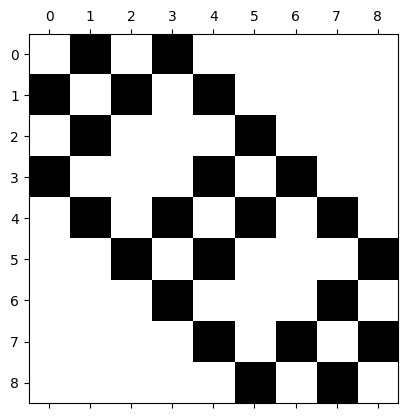

In [56]:
plt.spy(T)

In [50]:
A = np.zeros((9,9))